In [4]:
import lightkurve as lk
import numpy as np
import dynesty
import corner
import scipy 

In [2]:
kic = '4448777'

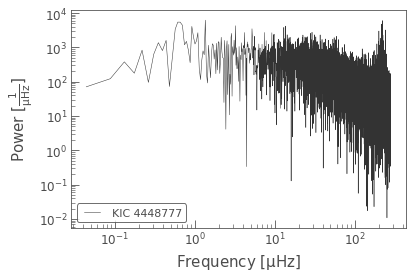

In [3]:
lc = lk.search_lightcurve('KIC ' + kic, author="Kepler", quarter=[8,9,10], cadence="long").download_all().stitch()
lc = lc.normalize()
lc.flux *= 1e6
pg = lc.to_periodogram(oversample_factor=1, normalization='PSD')
pg.plot(scale='log');

In [33]:
class dtwoterm():
    ''' At some point should JAX '''
    def __init__(self, pg):
        self.pg = pg
        self.f = self.pg.frequency.value
        self.O = self.pg.power.value
        
    def harvey(self, a, b, c=4):
        return a**2 / b / (1 + (self.f / b)**c)
    
    def eta(self):
        ''' TODO calculate just once'''
        x = np.pi * self.f / 2 / self.f.max()
        return np.sin(x) / x
    
    def hump(self, numax, width, height):
        return height * np.exp(-0.5 * (self.f - numax)**2 / width**2)
    
    def model(self, p): 
        a1, b1, a2, b2, numax, width, height, white = p
        return (self.harvey(a1, b1) + self.harvey(a2, b2) + self.hump(numax, width, height)) * self.eta()**2 + white
    
    def expand(self, l):
        ''' From Kalinger 2014'''
        numax, white, delta_a1, delta_a2, delta_height = l 
        p = [delta_a1 * 3382 * numax**-0.609, 
             0.317 * numax**0.970, 
             delta_a2 * 3382 * numax**-0.609, 
             0.948 * numax**0.992,
             numax, 
             0.3 * numax **0.8, 
             delta_height * 3335 * numax**-0.564, 
             white]
        return p
    
    def full_model(self, l):
        return self.model(self.expand(l))
    
    def loglike(self, l): 
        M = self.full_model(l)
        return -np.sum(np.log(M) + self.O/M)
    
    def ptform(self, u): 
        return [u[0] * 300, 
                u[1] * 1000,
                scipy.stats.norm.ppf(u[2]) * 0.1  + 1,
                scipy.stats.norm.ppf(u[3]) * 0.1  + 1,
                scipy.stats.norm.ppf(u[4]) * 0.3  + 1]
    
    def __call__(self): 
        self.sampler = dynesty.NestedSampler(self.loglike, self.ptform, 5,
                               nlive=200)
        self.sampler.run_nested()
        res = self.sampler.results
        
        samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
        new_samples = dynesty.utils.resample_equal(samples, weights)
        return new_samples
        

(10, 288)

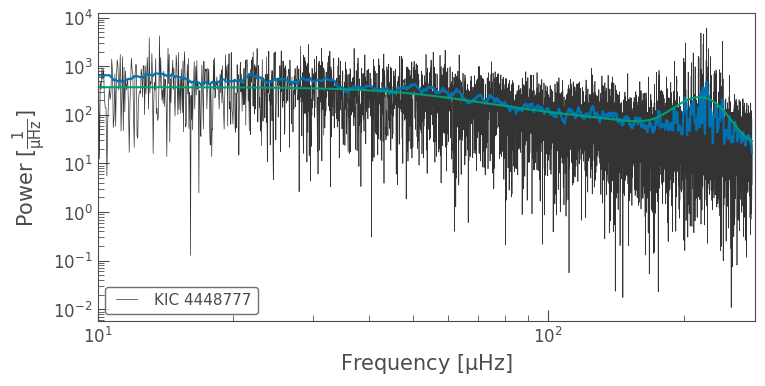

In [29]:
tt = dtwoterm(pg)

ax = pg.plot('log')
ax.plot(pg.frequency, pg.smooth(filter_width=2.0).power)
ax.plot(pg.frequency, tt.full_model([220, 20, 1., 1., 2.]))
ax.set_xlim([10, 288])

In [30]:
res = tt()

4314it [00:27, 154.94it/s, +200 | bound: 68 | nc: 1 | ncall: 28240 | eff(%): 16.098 | loglstar:   -inf < -38228.816 <    inf | logz: -38248.745 +/-  0.303 | dlogz:  0.001 >  0.209]


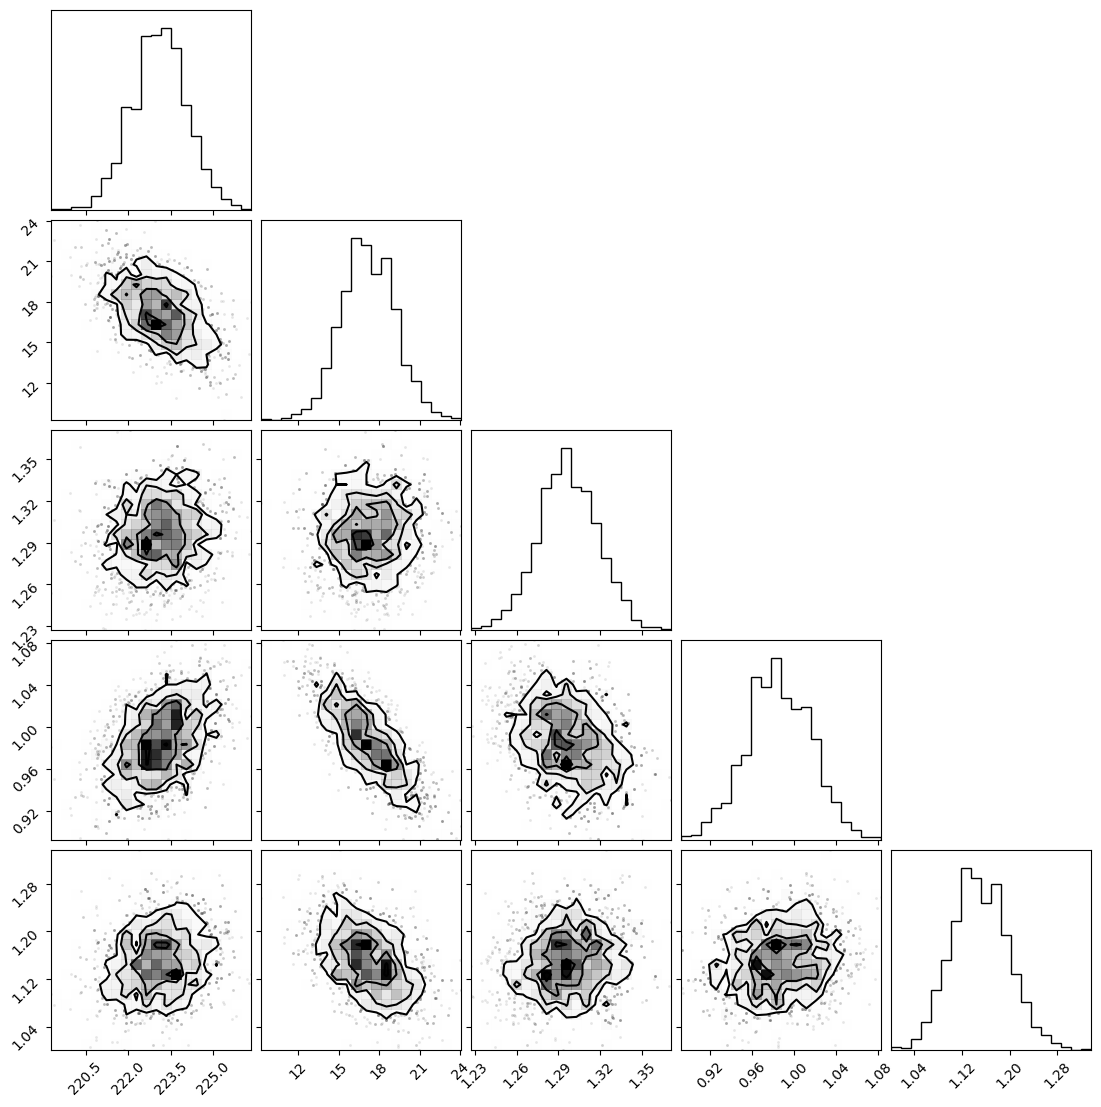

In [31]:
corner.corner(res);

(10, 288)

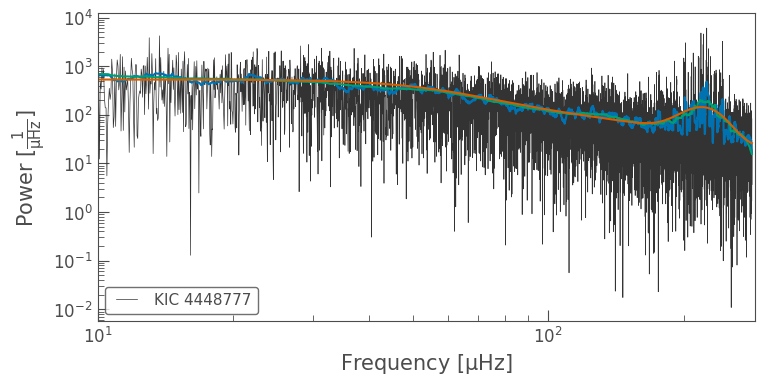

In [34]:
ax = pg.plot('log')
ax.plot(pg.frequency, pg.smooth(filter_width=2.0).power)
ax.plot(pg.frequency, pg.smooth(filter_width=20.0).power)
ax.plot(pg.frequency, tt.full_model(res.mean(axis=0)))
ax.set_xlim([10, 288])